# 丛集模式分析

In [40]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

font_cn = FontProperties(fname=r"C:\Windows\Fonts\simsun.ttc")
font_en = FontProperties(fname=r"C:\Windows\Fonts\times.ttf")


## 1.小时+工作日非工作日级别丛集模式的流量统计
  - （24h/工作日非工作日）统计丛集模式的总流量，刻画丛集模式的时间分布特征（上下两个柱状图比较）

In [41]:
def plot_cluster_flow_time_distribution_by_files(folder_path: str):
    """
    基于已分好时间切片的文件，统计丛集模式流量并绘制双柱状图
    （每个小时两根柱：左工作日，右非工作日）
    """

    # 初始化 24h × 2
    flow_workday = np.zeros(24)
    flow_nonworkday = np.zeros(24)

    # 文件名示例：od_flow_cluster_工作日_0.csv
    pattern = re.compile(r"_(工作日|非工作日)_(\d+)\.csv")

    for fname in os.listdir(folder_path):
        match = pattern.search(fname)
        if not match:
            continue

        day_type, hour = match.groups()
        hour = int(hour)

        df = pd.read_csv(os.path.join(folder_path, fname))

        # 只保留丛集模式流
        df = df[df["cluster_id"] != -1]

        # 该时间切片的丛集模式总流量
        flow_sum = df["flow_num"].sum()

        if day_type == "工作日":
            flow_workday[hour] += flow_sum
        else:
            flow_nonworkday[hour] += flow_sum

    # ---------- 绘图 ----------
    fig, ax = plt.subplots(figsize=(10, 4))

    x = np.arange(24)
    bar_width = 0.4

    ax.bar(
        x - bar_width / 2,
        flow_workday,
        width=bar_width,
        label="工作日"
    )
    ax.bar(
        x + bar_width / 2,
        flow_nonworkday,
        width=bar_width,
        label="非工作日"
    )
    
    ax.set_xticks(x)
    ax.set_xticklabels(
        [f"{h}-{h+1}" for h in x],
        rotation=45,
        ha="right"
    )
    # ax.set_xlabel("时间段（小时）")
    # ax.set_ylabel("丛集模式总流量")
    # ax.set_title("丛集模式共享单车流量的时间分布特征")
    ax.set_title(
        "丛集模式共享单车流量时间分布",
        fontproperties=font_cn
    )
    ax.set_xlabel(
        "时间段（小时）",
        fontproperties=font_cn
    )

    ax.set_ylabel(
        "丛集模式流量（次）",
        fontproperties=font_cn
    )

    ax.legend(
        prop=font_cn
    )
    plt.tight_layout()

    return fig, ax

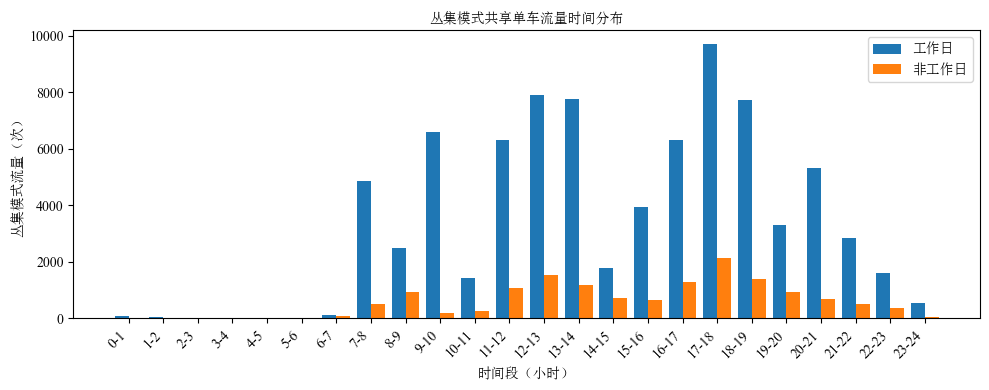

In [42]:
fig, ax = plot_cluster_flow_time_distribution_by_files(r"H:\code\shared_bike_pattern_mining\data\24_weekday_weekend_clusters")
fig.savefig("01_cluster_distributions.png", dpi=500)

## 2. 单时间段的流分析——流可视化（单线条，粗细代表流量大小）

In [46]:
def plot_cluster_flow(
    csv_path: str,
    linewidth_scale: float = 0.0005,
    title: str = "丛集—丛集共享单车流空间分布"
):
    """
    构建 cluster-to-cluster 流空间可视化
    """

    df = pd.read_csv(csv_path)

    # 去掉噪声
    df = df[df["cluster_id"] != -1]

    # ---------- 按 cluster 聚合 ----------
    clusters = (
        df.groupby("cluster_id")
        .agg(
            ox=("origin_lon", "mean"),
            oy=("origin_lat", "mean"),
            dx=("destination_lon", "mean"),
            dy=("destination_lat", "mean"),
            flow=("flow_num", "sum")
        )
        .reset_index()
    )

    # ---------- 线宽缩放（推荐 sqrt，视觉更稳定） ----------
    clusters["lw"] = np.sqrt(clusters["flow"]) * linewidth_scale

    # ---------- 绘图 ----------
    fig, ax = plt.subplots(figsize=(8, 8))

    # 浅色底图（不画真实瓦片，期刊很常见）
    ax.set_facecolor("#f7f7f7")

    for _, row in clusters.iterrows():
        ax.annotate(
            "",
            xy=(row["dx"], row["dy"]),
            xytext=(row["ox"], row["oy"]),
            arrowprops=dict(
                arrowstyle="->",
                linewidth=row["lw"],
                color="#4c4c4c",
                alpha=0.8,
                shrinkA=0,
                shrinkB=0
            )
        )

    # ---------- 设置范围 ----------
    margin = 0.01
    ax.set_xlim(
        min(clusters[["ox", "dx"]].min()) - margin,
        max(clusters[["ox", "dx"]].max()) + margin
    )
    ax.set_ylim(
        min(clusters[["oy", "dy"]].min()) - margin,
        max(clusters[["oy", "dy"]].max()) + margin
    )

    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])

    # ---------- 标题 ----------
    ax.set_title(title, fontsize=12)

    # ---------- 指北针 ----------
    ax.annotate(
        "N",
        xy=(0.95, 0.15),
        xytext=(0.95, 0.05),
        arrowprops=dict(facecolor="black", width=2),
        ha="center",
        va="center",
        fontsize=10,
        xycoords=ax.transAxes
    )

    # ---------- 比例尺（简化版） ----------
    # 这里假设经纬度近似（校园尺度 OK）
    scale_len = 0.005  # 约 500m 量级
    x0, y0 = ax.get_xlim()[0], ax.get_ylim()[0]

    ax.plot(
        [x0 + 0.01, x0 + 0.01 + scale_len],
        [y0 + 0.01, y0 + 0.01],
        color="black",
        linewidth=2
    )
    ax.text(
        x0 + 0.01 + scale_len / 2,
        y0 + 0.012,
        "≈500 m",
        ha="center",
        va="bottom",
        fontsize=8
    )

    plt.tight_layout()
    return fig, ax

C:\Users\99776\AppData\Local\Temp\ipykernel_43700\1843916788.py:102: UserWarning: Glyph 19995 (\N{CJK UNIFIED IDEOGRAPH-4E1B}) missing from font(s) Times New Roman.
  plt.tight_layout()
C:\Users\99776\AppData\Local\Temp\ipykernel_43700\1843916788.py:102: UserWarning: Glyph 38598 (\N{CJK UNIFIED IDEOGRAPH-96C6}) missing from font(s) Times New Roman.
  plt.tight_layout()
C:\Users\99776\AppData\Local\Temp\ipykernel_43700\1843916788.py:102: UserWarning: Glyph 20849 (\N{CJK UNIFIED IDEOGRAPH-5171}) missing from font(s) Times New Roman.
  plt.tight_layout()
C:\Users\99776\AppData\Local\Temp\ipykernel_43700\1843916788.py:102: UserWarning: Glyph 20139 (\N{CJK UNIFIED IDEOGRAPH-4EAB}) missing from font(s) Times New Roman.
  plt.tight_layout()
C:\Users\99776\AppData\Local\Temp\ipykernel_43700\1843916788.py:102: UserWarning: Glyph 21333 (\N{CJK UNIFIED IDEOGRAPH-5355}) missing from font(s) Times New Roman.
  plt.tight_layout()
C:\Users\99776\AppData\Local\Temp\ipykernel_43700\1843916788.py:102: U

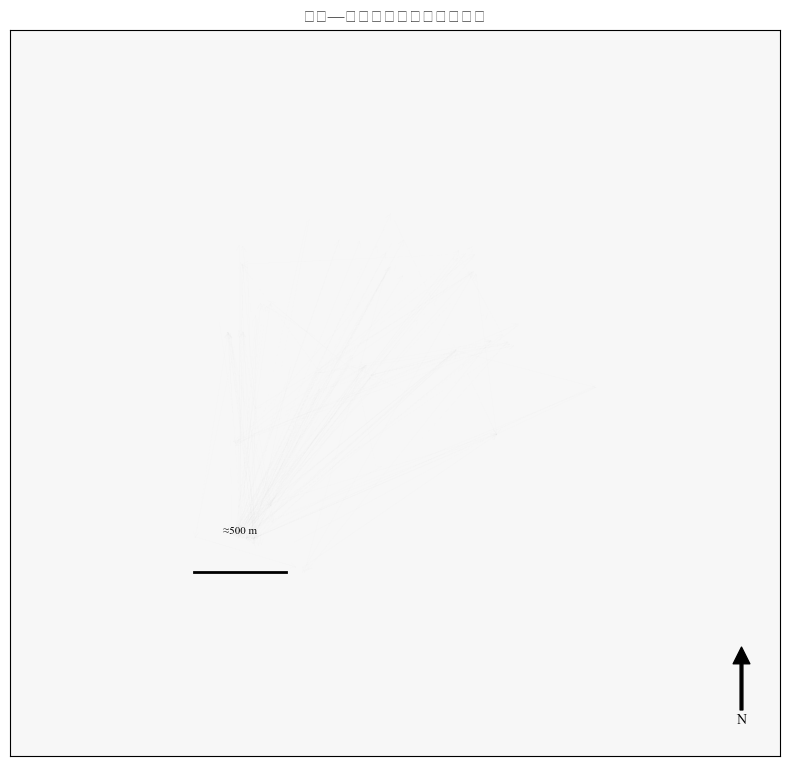

In [47]:
fig, ax = plot_cluster_flow(
    r"H:\code\shared_bike_pattern_mining\data\24_weekday_weekend_clusters\od_flow_cluster_非工作日_17.csv"
)
fig.savefig("01_cluster_to_cluster_flow.png", dpi=500)